# Download the dataset

In [ ]:
from google.colab import files
import os
files.upload()  # kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bglemser","key":"1b0d7921dada59101501451e17cb9c72"}'}

In [ ]:
!pip install -q kaggle

os.makedirs("/root/.kaggle", exist_ok=True)
if os.path.exists("kaggle.json"):
    os.replace("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)

In [ ]:
# 1. Kaggle Download & Unzip (automatisch)
import os

DATA_DIR = "/content/datasciencebowl"
TRAIN_DIR = os.path.join(DATA_DIR, "train")

# Kaggle API: Dataset herunterladen
if not os.path.exists("datasciencebowl.zip"):
    !kaggle competitions download -c datasciencebowl --quiet

# Hauptzip entpacken
if not os.path.exists(DATA_DIR):
    !unzip -q datasciencebowl.zip -d datasciencebowl

# Train, Test, SampleSubmission entpacken
!unzip -oq datasciencebowl/train.zip -d datasciencebowl/train
!unzip -oq datasciencebowl/test.zip -d datasciencebowl/test
!unzip -oq datasciencebowl/sampleSubmission.csv.zip -d datasciencebowl

# Doppelten train-Ordner zusammenführen (rsync)
if os.path.exists("datasciencebowl/train/train"):
    !rsync -a --ignore-existing datasciencebowl/train/train/ datasciencebowl/train/
    !rm -r datasciencebowl/train/train

print("Done!")



Done!


In [ ]:
# Checking
DATA_DIR = "/content/datasciencebowl"
print("Train classes:", len(os.listdir(f"{DATA_DIR}/train")))
print("Test :",  len(os.listdir(f"{DATA_DIR}/test")))

Train classes: 121
Test : 1


# Work with classes

In [ ]:
import pandas as pd
from PIL import Image
from collections import Counter

DATA_DIR = "/content/datasciencebowl"
TRAIN_DIR = os.path.join(DATA_DIR, "train")

In [ ]:
classes = sorted([
    d for d in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, d))
])

n_classes = len(classes)

print(f"Number of classes: {n_classes}")
print("First 10 classes:", classes[:10])

Number of classes: 121
First 10 classes: ['acantharia_protist', 'acantharia_protist_big_center', 'acantharia_protist_halo', 'amphipods', 'appendicularian_fritillaridae', 'appendicularian_s_shape', 'appendicularian_slight_curve', 'appendicularian_straight', 'artifacts', 'artifacts_edge']


In [ ]:
class_counts = {}

for cls in classes:
    cls_path = os.path.join(TRAIN_DIR, cls)
    class_counts[cls] = len([
        f for f in os.listdir(cls_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ])

df_counts = (
    pd.DataFrame.from_dict(class_counts, orient="index", columns=["num_images"])
    .sort_values("num_images", ascending=False)
)

df_counts

,num_images
trichodesmium_puff,1979
chaetognath_other,1934
copepod_cyclopoid_oithona_eggs,1189
protist_other,1172
detritus_other,914
...,...
pteropod_theco_dev_seq,13
hydromedusae_other,12
fish_larvae_deep_body,10
heteropod,10


In [ ]:
df_counts.describe()

,num_images
count,121.000000
mean,250.710744
std,338.852216
min,9.000000
25%,49.000000
50%,114.000000
75%,352.000000
max,1979.000000


# Sizes

In [ ]:
sizes = []

for cls in classes:
    cls_path = os.path.join(TRAIN_DIR, cls)

    for fname in os.listdir(cls_path):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(cls_path, fname)
            try:
                with Image.open(img_path) as img:
                    sizes.append(img.size)  # (width, height)
            except Exception as e:
                print(f"Error reading {img_path}: {e}")

df_sizes = pd.DataFrame(sizes, columns=["width", "height"])
df_sizes.describe()

,width,height
count,30336.000000,30336.000000
mean,73.507285,66.661821
std,49.162891,43.460964
min,31.000000,21.000000
25%,44.000000,43.000000
50%,56.000000,53.000000
75%,83.000000,72.000000
max,424.000000,428.000000


# PyTorch Dataset

In [ ]:
# 2. Imports
import copy
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [ ]:
from torch.utils.data import Dataset

# 3. Custom dataset
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, classes=None, transform=None):
        self.samples = []
        if classes is None:
            classes = sorted([
                d for d in os.listdir(root_dir)
                if os.path.isdir(os.path.join(root_dir, d))
            ])
        self.label2idx = {cls: i for i, cls in enumerate(classes)}
        for cls in classes:
            cls_path = os.path.join(root_dir, cls)
            for f in os.listdir(cls_path):
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.samples.append((cls, os.path.join(cls_path, f)))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label, path = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label2idx[label]

In [ ]:
# 4. Filter Classes by Threshold
classes = sorted([
    d for d in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, d))
])

class_counts = {
    cls: len([
        f for f in os.listdir(os.path.join(TRAIN_DIR, cls))
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ])
    for cls in classes
}

df_counts = pd.DataFrame.from_dict(class_counts, orient="index", columns=["num_images"])
df_counts = df_counts.sort_values("num_images", ascending=False)

threshold = 1
classes_filtered = df_counts[df_counts["num_images"] > threshold].index.tolist()
print(f"Filtered classes: {len(classes_filtered)}")

Filtered classes: 121


In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

pixel_sum = np.zeros(3)
pixel_sq_sum = np.zeros(3)
pixel_count = 0

for cls in tqdm(classes_filtered):
    cls_dir = os.path.join(TRAIN_DIR, cls)

    for f in os.listdir(cls_dir):
        img = np.array(
            Image.open(os.path.join(cls_dir, f)).convert("RGB"),
            dtype=np.float32
        )

        # shape: H x W x 3
        pixel_sum += img.sum(axis=(0, 1))
        pixel_sq_sum += (img ** 2).sum(axis=(0, 1))
        pixel_count += img.shape[0] * img.shape[1]

# mean / std per channel
global_mean = pixel_sum / pixel_count
global_std = np.sqrt(pixel_sq_sum / pixel_count - global_mean ** 2)

print("Global mean:", global_mean)
print("Global std:", global_std)



# global_mean = [mR, mG, mB]
# global_std  = [sR, sG, sB]

 67%|██████▋   | 2/3 [00:00<00:00, 10.46it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/content/datasciencebowl/train/...'

In [ ]:
# @title
# # 5. Compute global mean and std
# pixel_sum, pixel_sq_sum, pixel_count = 0, 0, 0
# for cls in tqdm(classes_filtered, desc="Calculating mean/std"):
#     cls_path = os.path.join(TRAIN_DIR, cls)
#     for f in os.listdir(cls_path):
#         if f.lower().endswith((".png", ".jpg", ".jpeg")):
#             img = np.array(Image.open(os.path.join(cls_path, f)).convert("RGB"), dtype=np.float32)
#             pixel_sum += img.sum()
#             pixel_sq_sum += (img ** 2).sum()
#             pixel_count += img.size

# global_mean = pixel_sum / pixel_count
# global_std = np.sqrt(pixel_sq_sum / pixel_count - global_mean**2)
# print(f"Global mean: {global_mean:.2f}, Global std: {global_std:.2f}")

# mean = global_mean / 255.0
# std  = global_std / 255.0

# Transformations and augmentations

#### Based on dataset statistics (median ≈ 55×52, 75th percentile ≈ 80×70)

In [ ]:
from torchvision import transforms

GLOBAL_MEAN = (global_mean / 255.0).tolist()
GLOBAL_STD  = (global_std  / 255.0).tolist()

train_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(GLOBAL_MEAN, GLOBAL_STD)
])

val_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(GLOBAL_MEAN, GLOBAL_STD)
])

In [ ]:
# 7. Dataset (без transform, только для split)
base_dataset = ImageFolderDataset(
    root_dir=TRAIN_DIR,
    classes=classes_filtered
)

labels = [base_dataset.label2idx[label] for label, _ in base_dataset.samples]
indices = list(range(len(base_dataset)))

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# 🔹 отдельные датасеты с разными transform
train_dataset = ImageFolderDataset(
    root_dir=TRAIN_DIR,
    classes=classes_filtered,
    transform=train_transform
)

val_dataset = ImageFolderDataset(
    root_dir=TRAIN_DIR,
    classes=classes_filtered,
    transform=val_transform
)

train_ds = Subset(train_dataset, train_idx)
val_ds   = Subset(val_dataset, val_idx)

In [ ]:
from torch.utils.data import DataLoader

# 8. DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# EfficientNet_B1


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT)
model.classifier[1] = nn.Linear(
    model.classifier[1].in_features,
    len(classes_filtered)
)
model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth


100%|██████████| 30.1M/30.1M [00:00<00:00, 62.9MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# @title
# for param in model.features.parameters():
#     param.requires_grad = False

# for param in model.classifier.parameters():
#     param.requires_grad = True

In [ ]:
import numpy as np
import torch
from collections import Counter

# ===== GET TRAIN LABELS FROM Subset =====
train_labels = [
    train_ds.dataset.label2idx[
        train_ds.dataset.samples[i][0]
    ]
    for i in train_ds.indices
]

train_labels = np.array(train_labels)

# ===== CLASS COUNTS =====
class_counts = np.bincount(train_labels)
num_classes = len(class_counts)

print("Class counts:", class_counts)

# ===== CLASS WEIGHTS (inverse frequency) =====
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * num_classes

class_weights = torch.tensor(
    class_weights,
    dtype=torch.float32,
    device=device
)

print("Class weights:", class_weights)

Class counts: [1583 1547  951  938  731  719  711  652  566  562  557  555  545  542
  500  429  426  415  409  400  386  351  340  334  330  315  314  308
  298  290  282  269  254  230  229  219  198  194  189  183  170  161
  152  143  142  140  139  138  136  126  122  120  113  109  108  106
  105  102  102   98   91   90   90   86   86   85   77   77   74   70
   70   68   64   62   61   60   58   57   52   51   50   49   46   45
   44   43   42   42   39   39   39   34   34   30   30   30   29   28
   25   24   24   23   23   22   19   19   19   19   17   15   13   13
   11   11   11   11   11   10    8    8    7]
Class weights: tensor([0.0279, 0.0286, 0.0465, 0.0471, 0.0604, 0.0614, 0.0621, 0.0678, 0.0781,
        0.0786, 0.0793, 0.0796, 0.0811, 0.0815, 0.0884, 0.1030, 0.1037, 0.1065,
        0.1080, 0.1105, 0.1145, 0.1259, 0.1299, 0.1323, 0.1339, 0.1403, 0.1407,
        0.1434, 0.1483, 0.1523, 0.1567, 0.1642, 0.1739, 0.1921, 0.1929, 0.2017,
        0.2231, 0.2277, 0.2338, 0.24

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(
        self,
        alpha=None,
        gamma=2.0,
        label_smoothing=0.0,
        reduction="mean"
    ):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        self.reduction = reduction

    def forward(self, logits, targets):
        num_classes = logits.size(1)

        # ---- one-hot with label smoothing ----
        with torch.no_grad():
            true_dist = torch.zeros_like(logits)
            true_dist.fill_(self.label_smoothing / (num_classes - 1))
            true_dist.scatter_(1, targets.unsqueeze(1), 1.0 - self.label_smoothing)

        log_probs = F.log_softmax(logits, dim=1)
        probs = log_probs.exp()

        # ---- focal weight ----
        pt = (probs * true_dist).sum(dim=1)
        focal_weight = (1 - pt) ** self.gamma

        # ---- cross-entropy with smoothed labels ----
        ce_loss = -(true_dist * log_probs).sum(dim=1)

        # ---- class weights ----
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            ce_loss = ce_loss * alpha_t

        loss = focal_weight * ce_loss

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss

In [ ]:
# @title
## 3 types of losses

# criterion = FocalLoss(
#     alpha=class_weights,
#     gamma=1.5,  # можно потом попробовать 2.0
# )

#criterion = nn.CrossEntropyLoss(weight=class_weights)

# criterion = nn.CrossEntropyLoss()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


# criterion = FocalLoss(
#     alpha=class_weights,
#     gamma=1,  # можно потом попробовать 2.0
# )



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#adding scheduler to pace learning rate

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
 #   optimizer,
  #  mode="min",
   # factor=0.5,
    #patience=3
#)

#mit f1 as metric

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",        # ⬅️ WICHTIG
    factor=0.5,
    patience=3
)


In [ ]:
epochs = 30
patience = 5

train_losses, val_losses, val_f1_scores = [], [], []
best_f1 = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # ===== TRAIN =====
    model.train()
    running_train_loss = 0.0

    train_pbar = tqdm(train_loader, desc="Train", leave=False)

    for x, y in train_pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        train_pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ===== VALIDATION =====
    model.eval()
    running_val_loss = 0.0
    all_preds, all_labels = [], []

    val_pbar = tqdm(val_loader, desc="Val", leave=False)

    with torch.no_grad():
        for x, y in val_pbar:
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)
            running_val_loss += loss.item()

            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            val_pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_f1 = f1_score(all_labels, all_preds, average="macro")
    val_f1_scores.append(val_f1)

    # scheduler.step(avg_val_loss)
    #scheduler with f1 score
    scheduler.step(val_f1)

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"Val Macro-F1: {val_f1:.4f}"
    )

    # ===== EARLY STOPPING =====
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, "best_model.pt")  # <-- für Kaggle-Inference speichern
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(best_model_wts)

AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


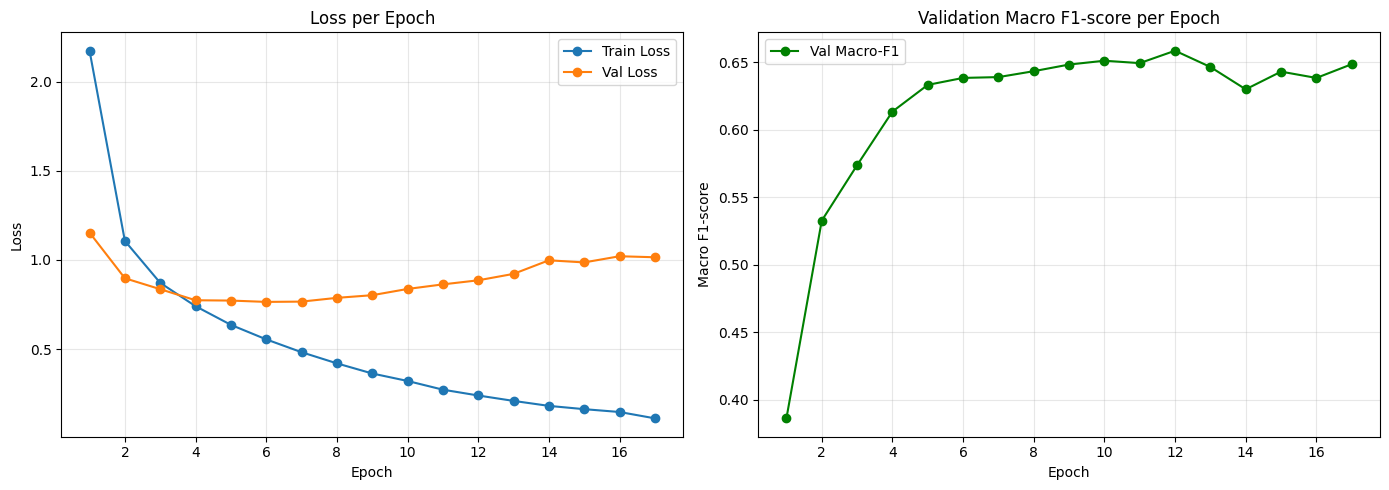

In [ ]:
import matplotlib.pyplot as plt

# оси X под каждую метрику
epochs_loss = range(1, len(train_losses) + 1)
epochs_f1   = range(1, len(val_f1_scores) + 1)

plt.figure(figsize=(14, 5))

# ===== LOSS =====
plt.subplot(1, 2, 1)
plt.plot(epochs_loss, train_losses, marker='o', label='Train Loss')
plt.plot(epochs_loss, val_losses, marker='o', label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)

# ===== MACRO F1 =====
plt.subplot(1, 2, 2)
plt.plot(
    epochs_f1,
    val_f1_scores,
    marker='o',
    color='green',
    label='Val Macro-F1'
)
plt.title("Validation Macro F1-score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Macro F1-score")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("training_curves.png", dpi=300)
plt.show()

In [ ]:
#claculate macro F1 score

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Confusion matrix"):
        x = x.to(device)
        y = y.to(device)

        out = model(x)
        preds = out.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

Confusion matrix: 100%|██████████| 185/185 [00:09<00:00, 19.99it/s]
